<a href="https://colab.research.google.com/github/Jaacunamatata/git-started/blob/jose/Find_circles_in_webcam_stream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Find circles in webcam stream
Jose Barreiros, 2022

## Open the camera and record a video

When recording the video, show circular objects or drawings of circles.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def record_video(filename='video.mp4'):
  js = Javascript("""
    async function recordVideo() {
      // mashes together the advanced_outputs.ipynb function provided by Colab,
      // a bunch of stuff from Stack overflow, and some sample code from:
      // https://developer.mozilla.org/en-US/docs/Web/API/MediaStream_Recording_API

      // Optional frames per second argument.
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      capture.textContent = "Start Recording";
      capture.style.background = "green";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      // create a media recorder instance, which is an object
      // that will let you record what you stream.
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);
      // Video is a media element.  This line here sets the object which serves
      // as the source of the media associated with the HTMLMediaElement
      // Here, we'll set it equal to the stream.
      video.srcObject = stream;
      // We're inside an async function, so this await will fire off the playing
      // of a video. It returns a Promise which is resolved when playback has
      // been successfully started. Since this is async, the function will be
      // paused until this has started playing.
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      // and now, just wait for the capture button to get clicked in order to
      // start recording
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);
      // use a promise to tell it to stop recording
      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();

      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();

      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
      return btoa(binaryString);
    }
    """)
  try:
    display(js)
    data = eval_js('recordVideo({})')
    binary = b64decode(data)
    with open(filename, "wb") as video_file:
      video_file.write(binary)
    print(
        f"Finished recording video. Saved binary under filename in current working directory: {filename}"
    )
  except Exception as err:
      # In case any exceptions arise
      print(str(err))
  return filename

In [ ]:
# Run the function, get the video path as saved in your notebook, and play it back here.
from IPython.display import HTML
from base64 import b64encode

video_width = 300

video_path = record_video()
video_file = open(video_path, "r+b").read()

video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

<IPython.core.display.Javascript object>

Finished recording video. Saved binary under filename in current working directory: video.mp4


## Algorithm

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import time

## TODO
## optimize this function to work better and faster

def find_circles(frame,show=False):
    #converts RGB image to gray for circle detection
    gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #enhance the gray frame
    alpha = 2. # Contrast control (0.0 - 3.0)
    gray_enhanced = cv2.convertScaleAbs(gray, alpha=alpha)
    if show:
      #resizing for ploting
      scale_percent = 60 # percent of original size
      w = int(gray_enhanced.shape[1] * scale_percent / 100)
      h = int(gray_enhanced.shape[0] * scale_percent / 100)
      dim = (w, h)
      # display frame
      cv2_imshow(cv2.resize(frame,dim))
      #display gray_enhanced
      cv2_imshow(cv2.resize(gray_enhanced,dim))

    #find edges
    gray_edged=cv2.Canny(gray_enhanced,20,130) #canny edge detector
    #gray_edged= cv2.Sobel(gray_enhanced, ddepth=-1, dx=1, dy=1, ksize=5) # Sobel Edge detector
    if show:
      cv2_imshow(cv2.resize(gray_edged,dim))

    #apply hough transform. Documentation: https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d
    n=4 #max number of circles that can be detected per frame
    circles = cv2.HoughCircles(gray_edged, cv2.HOUGH_GRADIENT, 1, minDist=50,param1 = 50, param2 = 60, minRadius = 10, maxRadius = 100)
    frame_with_circles=frame.copy()
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int") #extract coordinates of center and radius of circle
        for (x, y, r) in circles[0:min(len(circles),n)]:
          if show:
            print("x: ", x,"y: ", y,"rad: ",r)
          # draw found circles in the frame
          cv2.circle(frame_with_circles,(x, y), r, (0,255,0), 2)
    if show:
      cv2_imshow(cv2.resize(frame_with_circles,dim))

    return frame_with_circles


##Test algorithm in a few frames



----Frame # 0


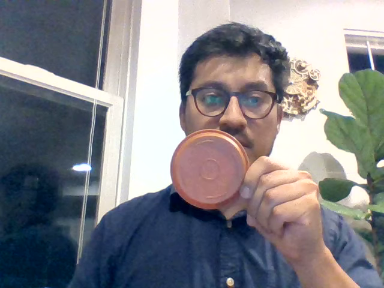

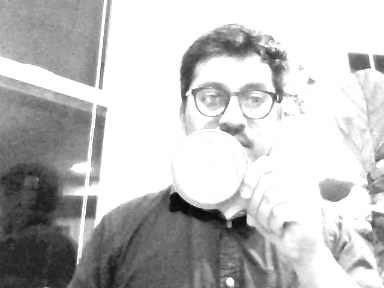

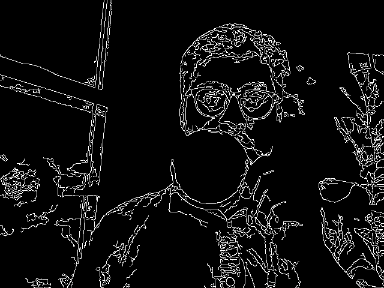

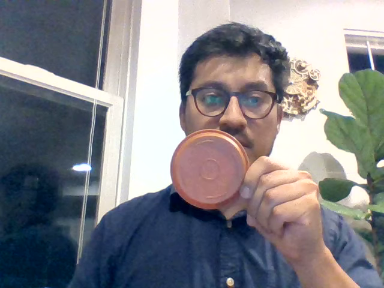

elapsed time:  0.21028900146484375 sec


----Frame # 50


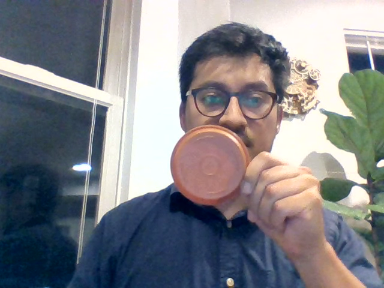

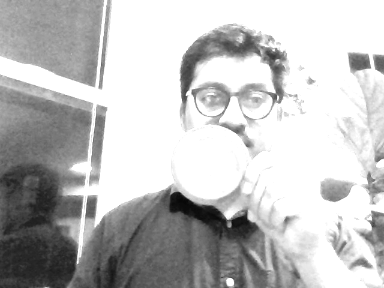

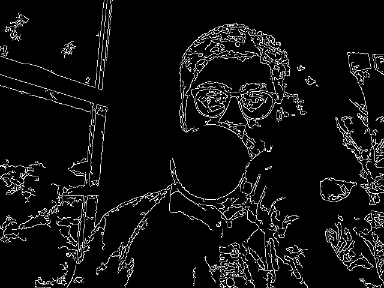

x:  388 y:  130 rad:  83
x:  352 y:  166 rad:  30
x:  420 y:  174 rad:  34


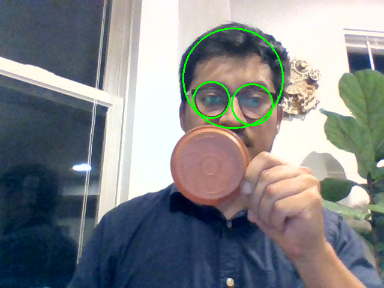

elapsed time:  0.23314619064331055 sec


----Frame # 10


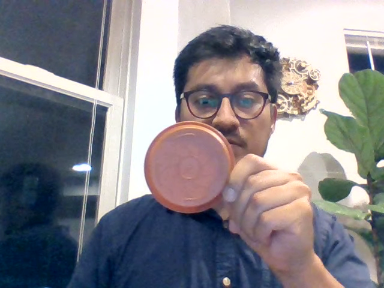

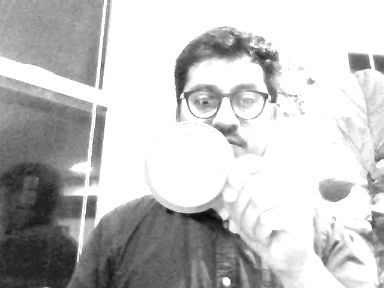

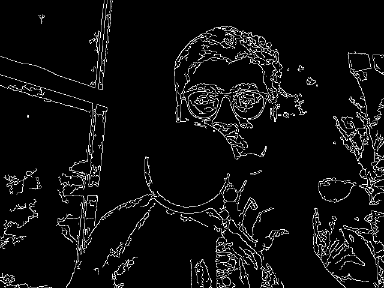

x:  382 y:  146 rad:  64


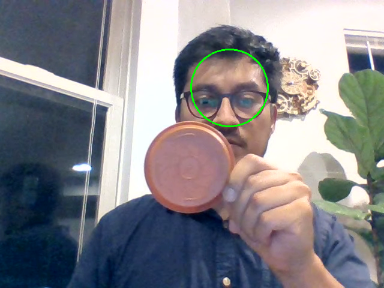

elapsed time:  0.23951506614685059 sec


In [ ]:

vidcap_ = cv2.VideoCapture('video.mp4')
vidcap_.set(cv2.CAP_PROP_POS_AVI_RATIO,0)

#select the nth frames
nths=[0,50, 10, 500]

success,image = vidcap_.read()
count = 0
frames=[]
while success:
  if count in nths:
    frames.append(image)

  success,image = vidcap_.read()
  count += 1

for i,frame in enumerate(frames):
  print("\n\n----Frame #",nths[i])
  # test algorith
  tic=time.time()
  frame_with_circles=find_circles(frame,show=True)
  toc=time.time()
  print("elapsed time: ", toc-tic, "sec")

## Process the entire video
It converts the video into frames. Each frame is process with a Hough transform to find circles, circles are then draw and superposed into the frame.

In [ ]:
%rm -r output
%mkdir output



vidcap = cv2.VideoCapture('video.mp4')
vidcap.set(cv2.CAP_PROP_POS_AVI_RATIO,0)

frameCount = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
videoFPS = int(vidcap.get(cv2.CAP_PROP_FPS))

print (f"frameWidth: {frameWidth}")
print (f"frameHeight: {frameHeight}")

success,image = vidcap.read()
count = 0

while success:
   cv2.imwrite("output/frame%d.jpg" % count, image)     # save frame as JPEG file
   success,image = vidcap.read()
   #print('Read a new frame: ', success)
   count += 1
print(count)

rm: cannot remove 'output': No such file or directory
frameWidth: 640
frameHeight: 480
130


In [ ]:
##It applies algorithm and converts the frames to video
%rm -r output_vid
%mkdir output_vid
import os
import natsort


image_folder = 'output'
video_name = 'output_vid/output.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
#print(images)
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
print(frame.shape)
fps=30
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc('M','J','P','G'), fps, (width,height))

print("number of images: ",len(images))
for image in natsort.natsorted(images,reverse=False):
    im=cv2.imread(os.path.join(image_folder, image))

    ### apply filter
    im=frame_with_circles=find_circles(im)
    ###
    video.write(im)

video.release()

#convert avi to mp4
!ffmpeg -i output_vid/output.avi output_vid/output.mp4

rm: cannot remove 'output_vid': No such file or directory
(480, 640, 3)
number of images:  130
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --ena

## Visualize the annotated video

In [ ]:
#open and play
mp4 = open('output_vid/output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=300 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)